In [79]:
### BASIC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

### KERAS
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [122]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<AxesSubplot:>

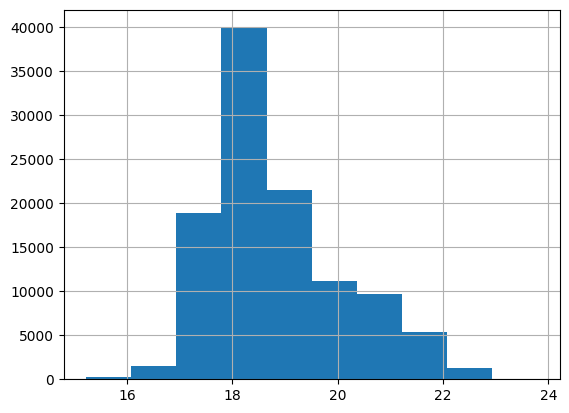

In [124]:
train["PIA205B-02A_MIN"].hist()

### 전처리

In [81]:
train.loc[train['PRESSURE-S'] < 60, 'PRESSURE-S'] = np.nan
test.loc[test['PRESSURE-S'] < 60, 'PRESSURE-S'] = np.nan

train.fillna(train['PRESSURE-S'].mean(), inplace = True)
test.fillna(train['PRESSURE-S'].mean(), inplace = True)

train.drop('datetime', axis = 1, inplace = True)
test.drop('datetime', axis = 1, inplace = True)

summer = train.loc[(train['lunMonth'] >= 3) & (train['lunMonth'] <= 8)].index
other = train.loc[(train['lunMonth'] < 3) | (train['lunMonth'] > 8)].index

train.loc[summer, 'lunMonth'] = 1
train.loc[other, 'lunMonth'] = 0

summer = test.loc[(test['lunMonth'] >= 3) & (test['lunMonth'] <= 8)].index
other = test.loc[(test['lunMonth'] < 3) | (test['lunMonth'] > 8)].index

test.loc[summer, 'lunMonth'] = 1
test.loc[other, 'lunMonth'] = 0

train['BOG'] = train['FY_SUM'] + train['FIA_SUM']
test['BOG'] = test['FY_SUM'] + test['FIA_SUM']

train['new'] = (train['LP_TOTAL'] / train['FY_SUM'] ) - 12
train['new1'] = (train['LP_TOTAL'] / train['BOG'] )
train['new2'] = (train['FI_SUM'] + train['FY_SUM'] + train['LP_TOTAL']) / train['TI_MEAN']
train['new3'] = ((train['PIA205B-02A_MIN'] + train['PIA205B-02A_MAX']) / 2) / (train['기온'] + 273.15) # 샤를의 법칙

test['new'] = (test['LP_TOTAL'] / test['FY_SUM'] ) - 12
test['new1'] = (test['LP_TOTAL'] / test['BOG'] )
test['new2'] = (test['FI_SUM'] + test['FY_SUM'] + test['LP_TOTAL']) / test['TI_MEAN']
test['new3'] = ((test['PIA205B-02A_MIN'] + test['PIA205B-02A_MAX']) / 2) / (test['기온'] + 273.15)

train.drop(['습도', '풍향','lunDay','lunYear','lunMonth','FIA_SUM', 'FI_SUM', 'FY_SUM','BOG' ], axis = 1, inplace = True) #  
test.drop(['습도','풍향','lunDay','lunYear','lunMonth', 'FIA_SUM', 'FI_SUM', 'FY_SUM','BOG'], axis = 1, inplace = True) # 

### Regressor Base

In [4]:
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [5]:
#poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=True, order='C')

In [6]:
#poly.fit(train)

In [7]:
#train = poly.transform(train)

In [8]:
#test = poly.transform(test)

In [9]:
#train = pd.DataFrame(train)
#test = pd.DataFrame(test)

In [10]:
#train = train.rename(columns = {1:"PIA205B-02A_MIN", 2 : 'PIA205B-02A_MAX'})
#test = test.rename(columns = {1:"PIA205B-02A_MIN", 2 : 'PIA205B-02A_MAX'})

In [82]:
def train_maker(train) :
    train_seq = []
    train_y = []

    for i in tqdm(range(len(train)-6)) :
        temp = train.iloc[i:i+6]
        y = train.iloc[i+6]
        y = y[['PIA205B-02A_MIN', 'PIA205B-02A_MAX']]
              
        # 맨 앞시점 버리기
        temp = temp.iloc[4:]
        train_seq.append(temp)
        train_y.append(y)
        
    return train_seq, train_y

def test_maker(test) :
    test_seq = []

    for i in tqdm(range(0,len(test),6)) :
    
        temp = test.iloc[i:i+6]
    
        # 맨 앞시점 버리기
        temp = temp.iloc[4:]
        test_seq.append(temp)
    
    return test_seq

In [83]:
train_seq, train_y = train_maker(train)
train_seq = np.array(train_seq)
train_y = np.array(train_y)
print("train_seq shape : ", train_seq.shape)
print("train_y shape : ", train_y.shape)

  0%|          | 0/109722 [00:00<?, ?it/s]

train_seq shape :  (109722, 2, 12)
train_y shape :  (109722, 2)


In [84]:
test_seq = test_maker(test)
test_seq = np.array(test_seq)
print("test_seq shape : ", test_seq.shape)

  0%|          | 0/5508 [00:00<?, ?it/s]

test_seq shape :  (5508, 2, 12)


### Transformer

In [89]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [90]:
tf.keras.backend.clear_session()

In [91]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    dropout=0
):
    # input 레이어 조정
    inputs = keras.Input(shape=input_shape)
    
    seq_last = inputs[:,-1,:]
    seq_last = tf.reshape(seq_last, [1,12])
    seq_last = layers.RepeatVector(2)(seq_last)
    
    x = tf.subtract(inputs, seq_last)
    x = tf.transpose(x, perm = [0,2,1])
    
    # transformers
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # end
    x = tf.transpose(x, perm = [0,2,1])
    x = tf.add(x, seq_last)
    
    # output
    outputs = x[:, -1, 1:3]
    
    return keras.Model(inputs, outputs)

In [95]:
input_shape = train_seq.shape[1:]

model = build_model(
    input_shape,
    head_size = 512,
    num_heads = 4,
    ff_dim = 4,
    num_transformer_blocks = 1,
    dropout = 0.9)

In [96]:
model.compile(
    loss = "mae",
    optimizer = keras.optimizers.Adam(lr =1e-2),#1e-2),
    metrics=["mse"]
)

In [97]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 12)]      0           []                               
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 12)          0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (1, 12)              0           ['tf.__operators__.getitem_2[0][0
                                                                 ]']                              
                                                                                            

In [98]:
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
            keras.callbacks.ModelCheckpoint('NLINEAR_poly__ffkkfKH.h5',monitor = 'val_loss',save_best_only = True,verbose = 1)]

In [99]:
model.fit(
    train_seq,
    train_y,
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    shuffle = True,
    callbacks=callbacks,
)

Epoch 1/200
685/686 [============================>.] - ETA: 0s - loss: 0.0523 - mse: 0.0273
Epoch 1: val_loss improved from inf to 0.01562, saving model to NLINEAR_poly__ffkkfKH.h5
686/686 [==============================] - 6s 6ms/step - loss: 0.0523 - mse: 0.0272 - val_loss: 0.0156 - val_mse: 0.0018
Epoch 2/200
686/686 [==============================] - ETA: 0s - loss: 0.0193 - mse: 0.0036
Epoch 2: val_loss did not improve from 0.01562
686/686 [==============================] - 4s 6ms/step - loss: 0.0193 - mse: 0.0036 - val_loss: 0.0163 - val_mse: 0.0018
Epoch 3/200
683/686 [============================>.] - ETA: 0s - loss: 0.0188 - mse: 0.0027
Epoch 3: val_loss did not improve from 0.01562
686/686 [==============================] - 4s 6ms/step - loss: 0.0188 - mse: 0.0027 - val_loss: 0.0182 - val_mse: 0.0020
Epoch 4/200
683/686 [============================>.] - ETA: 0s - loss: 0.0174 - mse: 0.0015
Epoch 4: val_loss did not improve from 0.01562
686/686 [==============================

KeyboardInterrupt: 

In [100]:
predict = model.predict(test_seq)

173/173 [==============================] - 1s 2ms/step


In [101]:
submission_sample = pd.read_csv("/home/kogas/KH/submission.csv")
submission_sample['PIA205B-02A_MIN'] = predict[:,0]
submission_sample['PIA205B-02A_MAX'] = predict[:,1]
submission_sample

,Unnamed: 0,TIME,PIA205B-02A_MIN,PIA205B-02A_MAX
0,0,2021-03-01 01:00:00,18.072001,18.111599
1,1,2021-03-01 02:20:00,17.516500,17.595900
2,2,2021-03-01 03:40:00,16.808502,17.089300
3,3,2021-03-01 05:00:00,16.500299,16.607100
4,4,2021-03-01 06:20:00,16.677299,16.820700
...,...,...,...,...
5503,5503,2021-12-31 18:20:00,17.959099,18.001801
5504,5504,2021-12-31 19:40:00,17.888899,17.937700
5505,5505,2021-12-31 21:00:00,17.876699,17.913300
5506,5506,2021-12-31 22:20:00,17.809500,17.843100


<AxesSubplot:>

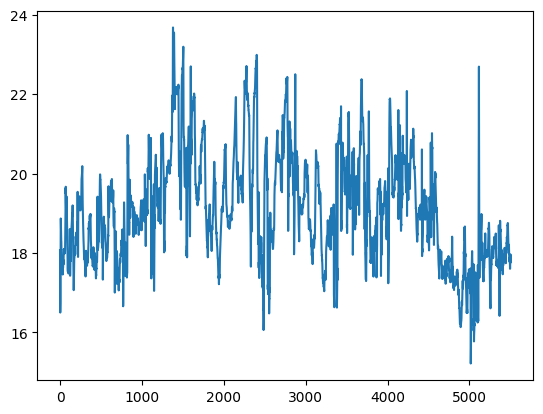

In [102]:
submission_sample["PIA205B-02A_MIN"].plot()

In [103]:
submission_sample.to_csv('NLINEAR_poly_KH__FFFF_1.csv', index = False)

In [125]:
final_rf = pd.read_csv("final_rf.csv")

In [113]:
poly = pd.read_csv("NLINEAR_poly_KH_1.csv")

In [133]:
final_rf['PIA205B-02A_MIN'] = final_rf['PIA205B-02A_MIN'].apply(lambda x : x * 0.95 if x >= 22 else x)
final_rf['PIA205B-02A_MAX'] = final_rf['PIA205B-02A_MAX'].apply(lambda x : x * 0.95 if x >= 22 else x)

In [134]:
final_rf.to_csv("0.95fsdafas.csv")

In [115]:
submission_sample = pd.read_csv("/home/kogas/KH/submission.csv")
submission_sample['PIA205B-02A_MIN'] = final_rf["PIA205B-02A_MIN"] * 0.8 + poly["PIA205B-02A_MIN"] * 0.2
submission_sample['PIA205B-02A_MAX'] = final_rf["PIA205B-02A_MAX"] * 0.8 + poly["PIA205B-02A_MAX"] * 0.2
submission_sample

,Unnamed: 0,TIME,PIA205B-02A_MIN,PIA205B-02A_MAX
0,0,2021-03-01 01:00:00,18.054504,18.094139
1,1,2021-03-01 02:20:00,17.456055,17.525817
2,2,2021-03-01 03:40:00,16.758600,16.926626
3,3,2021-03-01 05:00:00,16.552207,16.649201
4,4,2021-03-01 06:20:00,16.745736,16.833116
...,...,...,...,...
5503,5503,2021-12-31 18:20:00,17.963943,18.001904
5504,5504,2021-12-31 19:40:00,17.871828,17.919569
5505,5505,2021-12-31 21:00:00,17.872609,17.910463
5506,5506,2021-12-31 22:20:00,17.803286,17.835676


In [116]:
submission_sample.to_csv('BLD_FINAL.csv', index = False)